In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/zindi-crop-detection-final-tabular-data/train_final3.csv
/kaggle/input/zindi-crop-detection-final-tabular-data/test_final3.csv
/kaggle/input/zindi-crop-detection-final-tabular-data/sample_submission2.csv


In [2]:
import numpy as np 
import pandas as pd 
import os


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, log_loss, f1_score, accuracy_score, make_scorer

from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras import optimizers, callbacks 


from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization,Add,Dropout
from keras.models import Model, load_model

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils, plot_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
import collections

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

import gc

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
train = pd.read_csv('/kaggle/input/zindi-crop-detection-final-tabular-data/train_final3.csv')
test = pd.read_csv('/kaggle/input/zindi-crop-detection-final-tabular-data/test_final3.csv')
sample_sub = pd.read_csv('/kaggle/input/zindi-crop-detection-final-tabular-data/sample_submission2.csv')
print('train shape {}'.format(train.shape))
print('test shape {}'.format(test.shape))

train shape (2494, 10363)
test shape (1074, 10362)


In [4]:
# source : https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9'],
#                           target_names = ['0', '1'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
param = {
#     'seed': 1,
    'bagging_freq': 5,
    'boost_from_average':'true',
    'boost': 'gbdt',
    'n_estimators' : 200,
    'colsample_bytree': 0.4,
    'learning_rate': 0.1,
    'lambda_l1': 2, 
    'lambda_l2': 5, 
    'subsample': 0.4, # This specifies the fraction of rows to consider at each subsampling stage. By default it is set to 1, which means no subsampling.
    'subsample_freq ': 5,
    'metric':'multi_logloss',
    'min_data_in_leaf': 30,
    'num_leaves': 5,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'multiclass',
    "num_class" : 9,
    "is_unbalance" : True,
    'verbosity': 1
}

dates = ["2017-01-01", "2017-02-10", "2017-06-20", 
        "2017-07-10", "2017-07-15", "2017-08-04", "2017-08-19",
        "2017-01-31", "2017-03-12", "2017-03-22", "2017-05-31"]

features = ['red', 'green', 'blue', 'band5', 'band6', 'band7', 'nir', 'band8a', 'band11', 'band12',
           'ndvi', 'reip', 'datt3', 'gemi', 'msbi', 'ccci', 'avi', 'cvi', 'ndsi', 'siwsi', 'savi', 'evi', 'ndre',
            'cari', 'tvi', 'afair21', 'mnsi', 'afri16', 'cri550', 'cri770', 'tci', 'nbr', 'nd776', 'mcari', 'maccioni',
            'lci', 'epichla', 'gndvi2', 'gli'
           ]

columns = []
for date in dates:
    for layer in features:
        columns = columns + [
   layer+ '_val1'+date, layer+ '_val2'+date, layer+ '_val3'+date, layer+ '_val4'+date, layer+ '_val5'+date, layer+ '_val6'+date,
   layer+ '_val7'+date, layer+ '_val8'+date, layer+ '_val9'+date, layer+ '_val10'+date,
   layer+ '_val11'+date, layer+ '_val12'+date, layer+ '_val13'+date, layer+ '_val14'+date, layer+ '_val15'+date, layer+ '_val16'+date,
   layer+ '_val17'+date, layer+ '_val18'+date, layer+ '_val19'+date, layer+ '_val20'+date]

    
train_cols = columns + ['Crop_Id_Ne', 'Field_Id']
test_cols = columns + ['Field_Id']
X_train = train.drop(columns = train_cols, axis = 1)
X_train.reset_index(inplace = True, drop= True)
X_test = test.drop(columns = test_cols, axis = 1)
X_test.reset_index(inplace = True, drop= True)
y_train = train['Crop_Id_Ne']

print(len(X_train.columns.values))

1781


In [6]:
# Display/plot feature importance
# from here https://www.kaggle.com/hmendonca/lightgbm-predictions-explained-with-shap-0-796
def display_importances(feat_importance):
    best_features = feat_importance[["feature", "importance"]].groupby("feature")["importance"].agg(['mean', 'std']) \
                                                              .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean importance", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean importance", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [7]:
# source https://www.kaggle.com/hmendonca/lightgbm-predictions-explained-with-shap-0-796
def kfold_lightgbm(train,test,train_labels,params=None,num_class=9,metrics=None, debug=False, num_folds = 5,
                   stratified = False, log = False, seed = 1):
    
    oof_valid = np.zeros((len(train),num_class))
    oof_test  = np.zeros((len(test),num_class))    
    feat_importance = pd.DataFrame()
    cv_scores = [] ## cross validation scores in each kfold and overall cv score
    train_scores=[] ## train scores of each model trained on kfold
    models = [] ## save the models
    
    if stratified:
        kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    else:
        kf = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
    
    for ind, (trn_ind, val_ind) in ( enumerate( kf.split(train,train_labels)) ):
        
        xtr, xvl = train.loc[trn_ind], train.loc[val_ind]
        ytr, yvl = train_labels[trn_ind] , train_labels[val_ind]

        
#         dtrain=lgb.Dataset(data=X_train,label=y_train, feature_name=X_train.columns)
#         dval=lgb.Dataset(data=X_valid,label=y_valid, feature_name=X_valid.columns)
#         display(X_valid.shape)
        
        fit_params={"early_stopping_rounds":300, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(xvl,yvl)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}
 
        ## Fit the model with early stoping
        model = lgb.LGBMClassifier()
        model.set_params(**param)
        model.fit(xtr, ytr, **fit_params)
        best_iteration = model.best_iteration_
        
        ## predict on validation and test sets
        val_pred =model.predict(xvl, num_iteration=best_iteration)
        train_pred_prob = model.predict_proba(xtr, num_iteration=best_iteration)
        val_pred_prob = model.predict_proba(xvl, num_iteration=best_iteration) 
        test_pred_prob = model.predict_proba(test,num_iteration=best_iteration)
        oof_valid[val_ind,:] += np.array(val_pred_prob)
        oof_test += np.array(test_pred_prob)
        
        
        ## Print and calcualte the scores
        score_fold_validation = log_loss(yvl, val_pred_prob)
        cv_scores.append(score_fold_validation)
        score_fold_train = log_loss(ytr, train_pred_prob)
        train_scores.append(score_fold_train)
        
        if log:
            print('accuracy_score',accuracy_score(yvl,val_pred))
            print('f1 score ', f1_score(yvl, val_pred, average='weighted'))
            plot_confusion_matrix(confusion_matrix(val_pred, yvl))
    
        
        ## Calculate feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = test.columns.values
        fold_importance_df["importance"] = model.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(valid_x)[:,:test_df.shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = ind + 1
        feat_importance = pd.concat([feat_importance, fold_importance_df], axis=0)
        
        
        if not debug:
            pd.DataFrame(oof_preds).to_csv("lgb{:03}_{:.5f}_train_oof.csv".format(test_df.shape[1], score), index=False)
            sub_df = pd.read_csv('../input/sample_submission.csv')
            sub_df['TARGET'] = sub_preds
            sub_df.to_csv("lgb{:03}_{:.5f}.csv".format(test_df.shape[1], score), index= False)
        
        # Clear variables
        models.append(model)
        del model, xtr, xvl, ytr, yvl, fold_importance_df
        gc.collect()

        
        print('Iteration : {} - CV Score : {}'.format(str(ind+1),score_fold_validation))
        print('='* 80)
        
        
    oof_test /= num_folds
    
    end_train_score=np.mean(train_scores)
    oof_score=log_loss(train_labels, oof_valid)
    cv_scores.append(oof_score)
    print("ending  training  : train score {} - oof Score {}".format(str(end_train_score),str(oof_score)))

#     display_importances(feat_importance)
#     return feat_importance, models, cv_scores, oof_test, 
    return oof_test, cv_scores

Training until validation scores don't improve for 300 rounds.
[100]	valid's multi_logloss: 0.63093
[200]	valid's multi_logloss: 0.595151
Did not meet early stopping. Best iteration is:
[190]	valid's multi_logloss: 0.591957
accuracy_score 0.8383233532934131
f1 score  0.820479835621798


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


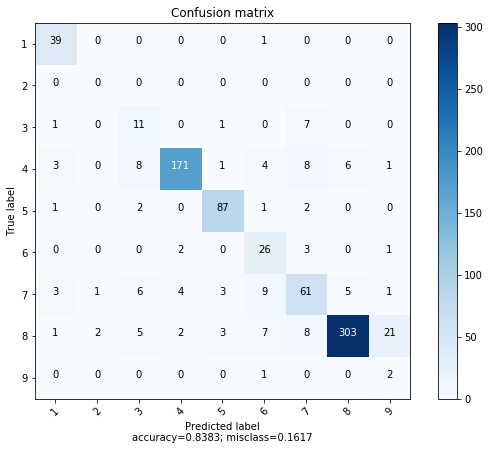

Iteration : 1 - CV Score : 0.5729597378762258
Training until validation scores don't improve for 300 rounds.
[100]	valid's multi_logloss: 0.670021
[200]	valid's multi_logloss: 0.619979
Did not meet early stopping. Best iteration is:
[200]	valid's multi_logloss: 0.619979
accuracy_score 0.8197115384615384
f1 score  0.8040814723709636


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


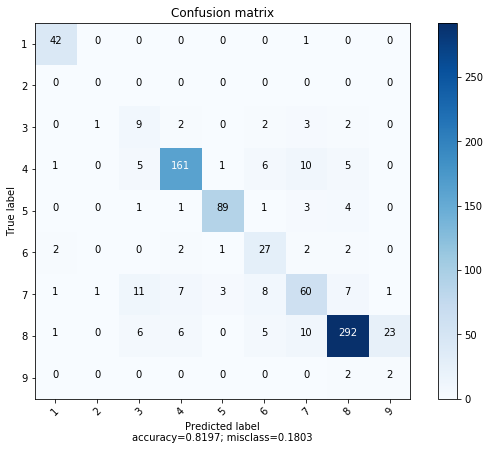

Iteration : 2 - CV Score : 0.6101250512158606
Training until validation scores don't improve for 300 rounds.
[100]	valid's multi_logloss: 0.589582
[200]	valid's multi_logloss: 0.543359
Did not meet early stopping. Best iteration is:
[198]	valid's multi_logloss: 0.543279
accuracy_score 0.8258766626360339
f1 score  0.8074427602547938


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


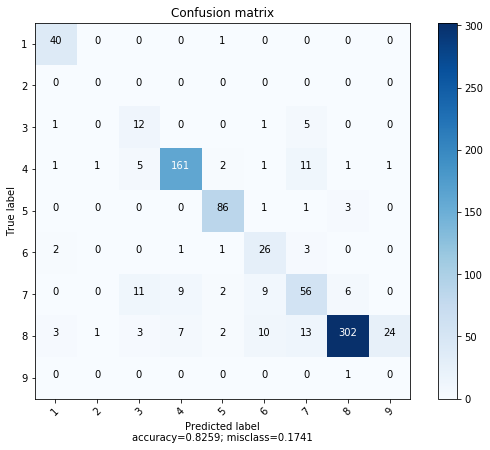

Iteration : 3 - CV Score : 0.5432794596129072
ending  training  : train score 0.16953188401118954 - oof Score 0.5755162537442338


In [8]:
# feat_importance, models, cv_scores, probabilities, =kfold_lightgbm(X_train,X_test,y_train,
y_test, cv_scores =kfold_lightgbm(X_train,X_test,y_train,
                        params=param,
                        num_class=9,
                        debug = True,
                        num_folds = 3,
                        stratified = True,
                        log = True)

[0.5729597378762258, 0.6101250512158606, 0.5432794596129072, 0.5755162537442338]
Counter({8: 448, 4: 252, 7: 134, 5: 111, 1: 56, 6: 43, 3: 26, 9: 4})
(1074, 9)


,field_id,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
0,5,0.009450,0.001367,0.001351,0.002076,0.001579,0.015875,0.001560,0.913379,0.053363
1,6,0.005027,0.001520,0.001868,0.002130,0.003311,0.011971,0.002315,0.894994,0.076864
2,10,0.003927,0.001006,0.005751,0.005851,0.000807,0.002513,0.001437,0.968156,0.010552
3,18,0.001101,0.000644,0.002040,0.001319,0.000598,0.002445,0.001824,0.985627,0.004401
4,23,0.000472,0.000494,0.000724,0.000392,0.000535,0.001925,0.000769,0.942002,0.052688
5,28,0.002398,0.001968,0.728853,0.008095,0.005385,0.027443,0.164110,0.057594,0.004154
6,32,0.001337,0.000324,0.000235,0.000256,0.000332,0.001483,0.000393,0.944764,0.050874
7,35,0.003400,0.001426,0.003629,0.004019,0.001239,0.004148,0.001169,0.897324,0.083647
8,43,0.006086,0.004759,0.061388,0.051383,0.004783,0.090506,0.703929,0.052294,0.024872
9,44,0.001610,0.002276,0.011735,0.021111,0.009737,0.096430,0.845610,0.007471,0.004020


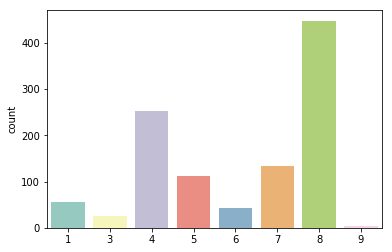

In [9]:
print(cv_scores)
prob = pd.DataFrame(y_test)

predicted_classes = y_test.argmax(1)+1
counter=collections.Counter(predicted_classes)
print(counter)
sns.countplot(predicted_classes, palette='Set3')

# prob = pd.DataFrame(get_prediction_from_np_array(test_predict))
prob.columns = ['crop_id_1', 'crop_id_2', 'crop_id_3', 'crop_id_4', 'crop_id_5', 'crop_id_6', 'crop_id_7','crop_id_8', 'crop_id_9']
print(prob.shape)

submission = pd.DataFrame()
submission['field_id'] = sample_sub['field_id']
submission = submission.join(prob)
submission.head(30)

In [10]:
file_name = 'lgbm_allv2_delete_val_columns_weak_learners_cv{:.5f}.csv'.format(cv_scores[-1])
# print(file_name)
submission.to_csv(file_name, index=False)

### Blending on seed

In [11]:
n = 20
all_cv_scores = []
num_class = 9
final_prob = np.zeros((len(X_test),num_class))
print(final_prob.shape)
stratified = True
for seed in range(1, n+1):
    print('seed number {}'.format(seed))
    param = {
        'seed': seed,
        'bagging_freq': 5,
        'boost_from_average':'true',
        'boost': 'gbdt',
        'n_estimators' : 200,
        'colsample_bytree': 0.4, # This specifies the fraction of columns to consider at each subsampling stage
        'learning_rate': 0.1,
        'lambda_l1': 2, 
        'lambda_l2': 5, 
        'subsample': 0.4, # This specifies the fraction of rows to consider at each subsampling stage. By default it is set to 1, which means no subsampling.
        'subsample_freq ': 5, # This specifies that bagging should be performed after every k iterations. By default it is set to 0. So make sure that you set it to some non-zero value if you want to enable subsampling.
        'metric':'multi_logloss',
        'min_data_in_leaf': 30,
        'num_leaves': 5,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'multiclass',
        "num_class" : 9,
        "is_unbalance" : True,
        'verbosity': 1
    }
    
    y_test, cv_scores =kfold_lightgbm(X_train,X_test,y_train,
                        params=param,
                        num_class=9,
                        debug = True,
                        num_folds = 3,
                        stratified = True,
                        seed = seed)
    predicted_classes = y_test.argmax(1)+1
    counter=collections.Counter(predicted_classes)
    print(counter)
    
    all_cv_scores.append(cv_scores[-1])
    final_prob += y_test
    
final_prob= final_prob/n
prob = pd.DataFrame(final_prob)
# prob = pd.DataFrame(get_prediction_from_np_array(test_predict))
prob.columns = ['crop_id_1', 'crop_id_2', 'crop_id_3', 'crop_id_4', 'crop_id_5', 'crop_id_6', 'crop_id_7','crop_id_8', 'crop_id_9']
#     print(prob.shape)

print(all_cv_scores)
print('mean overall log loss: ', np.mean(all_cv_scores))
submission = pd.DataFrame()
submission['field_id'] = sample_sub['field_id']
submission = submission.join(prob)
submission.head(30)
    

(1074, 9)
seed number 1
Training until validation scores don't improve for 300 rounds.
[100]	valid's multi_logloss: 0.632532
[200]	valid's multi_logloss: 0.587403
Did not meet early stopping. Best iteration is:
[199]	valid's multi_logloss: 0.587323
Iteration : 1 - CV Score : 0.5683707099077204
Training until validation scores don't improve for 300 rounds.
[100]	valid's multi_logloss: 0.634662
[200]	valid's multi_logloss: 0.593489
Did not meet early stopping. Best iteration is:
[199]	valid's multi_logloss: 0.593139
Iteration : 2 - CV Score : 0.593139060748073
Training until validation scores don't improve for 300 rounds.
[100]	valid's multi_logloss: 0.590386
[200]	valid's multi_logloss: 0.547992
Did not meet early stopping. Best iteration is:
[200]	valid's multi_logloss: 0.547992
Iteration : 3 - CV Score : 0.5377452586388215
ending  training  : train score 0.16724415103301707 - oof Score 0.5664781757055527
Counter({8: 449, 4: 256, 7: 127, 5: 116, 1: 52, 6: 43, 3: 27, 9: 4})
seed number 

,field_id,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
0,5,0.010698,0.001464,0.002267,0.003043,0.001991,0.024314,0.001789,0.910629,0.043804
1,6,0.007225,0.001752,0.002606,0.003821,0.004399,0.019495,0.002567,0.872566,0.085568
2,10,0.003457,0.001416,0.007591,0.007097,0.001294,0.003814,0.002428,0.946378,0.026525
3,18,0.000916,0.000570,0.001653,0.001091,0.000574,0.002146,0.001236,0.986189,0.005625
4,23,0.000490,0.000529,0.001181,0.000414,0.000683,0.002514,0.000795,0.961359,0.032035
5,28,0.002726,0.002434,0.675832,0.009230,0.006637,0.028550,0.221188,0.047864,0.005541
6,32,0.001605,0.000305,0.000275,0.000310,0.000358,0.001875,0.000356,0.944110,0.050807
7,35,0.002597,0.001567,0.005025,0.003371,0.001521,0.006449,0.002128,0.863172,0.114171
8,43,0.005890,0.005276,0.049338,0.061372,0.005677,0.127299,0.669197,0.049830,0.026121
9,44,0.001637,0.002734,0.011734,0.021645,0.011167,0.137016,0.799870,0.008776,0.005421


In [12]:
file_name = 'lgbm_allv2_delete_val_columns_blending_week_lerners_{}_seed_cv{:.5f}.csv'.format(n, np.mean(all_cv_scores))
# print(file_name)
submission.to_csv(file_name, index=False)